In [1]:
import torch
import random
import math
import hess
import hess.utils as utils
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
from hess.data import data_loader
import numpy as np
import copy

In [2]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
X, Y = twospirals(500, noise=1.5)
test_x, test_y = twospirals(100, 1.5)

In [4]:
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y).unsqueeze(-1)

In [5]:
loss_func = torch.nn.BCEWithLogitsLoss()

In [6]:
use_cuda =  torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(2)
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()

In [28]:
n_trial = 100
pct_keep = .25
optim = torch.optim.Adam

losses = torch.zeros(n_trial)
test_losses = torch.zeros(n_trial)
hessians = []

for tt in range(n_trial): 
    
    model = hess.nets.MaskedNet(train_x, train_y, bias=True, 
                            n_hidden=3, hidden_size=20,
                            activation=torch.nn.ELU(),
                            pct_keep=pct_keep)
    n_par = sum(p.numel() for p in model.parameters())
    if use_cuda:
        model = model.cuda()
    mask, perm = hess.utils.mask_model(model, pct_keep, use_cuda)
    keepers = np.array(np.where(mask.cpu() == 1))[0]
        
    ## compute the hessian of the masked network ##
    sub_hess = torch.zeros(n_par, n_par)
    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0)
        base_vec[0, pp] = 1.

        base_vec = utils.unflatten_like(base_vec, model.parameters())
        utils.eval_hess_vec_prod(base_vec, model.parameters(),
                                net=model,
                                criterion=torch.nn.BCEWithLogitsLoss(),
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = utils.gradtensor_to_tensor(model, include_bn=True)
            sub_hess = torch.zeros(output.nelement(), output.nelement())
            sub_hess[:, pp] = output


        sub_hess[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()
    
    mask = hess.utils.get_mask(model)
    ## extract the indices of the hessian we care about ##
    keepers = np.array(np.where(mask == 1))[0]
    hessians.append(sub_hess[np.ix_(keepers, keepers)])

#     optimizer=optim(model.parameters(), lr=lr)

#     for step in range(n_iters):
#         optimizer.zero_grad()
#         outputs = model(train_x)

#         loss=loss_func(outputs,train_y)
#         losses[tt, step] = loss
#         loss.backward()
#         optimizer.step()
        
#         test_out = model(test_x)
#         test_loss = loss_func(test_out, test_y)


    ## now compute the losses for the subnetwork ##
    outputs = model(train_x)
    losses[tt] = loss_func(outputs, train_y)
    
    outputs = model(test_x)
    test_losses[tt] = loss_func(outputs, test_y)
    
    if tt%10 == 0:
        print("model ", tt, " done")

model  0  done
model  10  done
model  20  done
model  30  done
model  40  done
model  50  done
model  60  done
model  70  done
model  80  done
model  90  done


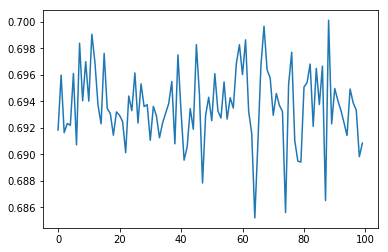

In [29]:
plt.plot(losses.detach())

In [30]:
idx = losses.argsort()
sorted_losses = losses[idx]

In [31]:
idx

tensor([64, 74, 87, 47, 79, 78, 41, 98, 22, 42,  6, 38, 65, 99, 77, 30, 33, 94,
        18, 63,  2,  0, 44, 83,  4, 89, 14,  3, 34, 26, 93, 21, 50, 55, 53, 32,
        48, 20, 70, 17, 35, 19, 73, 62, 40, 52, 24, 92, 97, 43, 16, 57, 28, 31,
        72, 13, 29, 85, 36, 96, 10,  8, 91, 56, 49, 23, 46, 71, 95, 90, 80, 75,
        27, 81, 54, 37, 69,  1, 60, 51,  5, 25, 68, 84, 86, 66, 82, 58, 12,  9,
        39, 15, 76, 59, 45,  7, 61, 11, 67, 88])

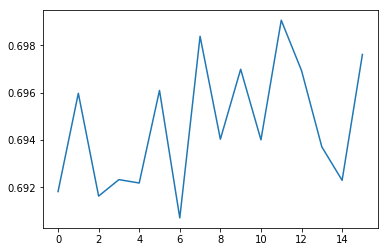

In [32]:
plt.plot(losses[:16].detach())

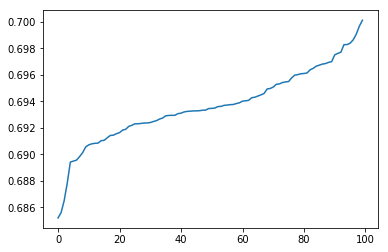

In [33]:
plt.plot(sorted_losses.detach())

In [34]:
e_vals = []
for tt in range(n_trial):
    e_val, _ = np.linalg.eig(hessians[tt].cpu())
    tidx = np.abs(e_val).argsort()[::-1]   
    e_val = torch.FloatTensor(e_val[tidx].real)
    e_vals.append(e_val)

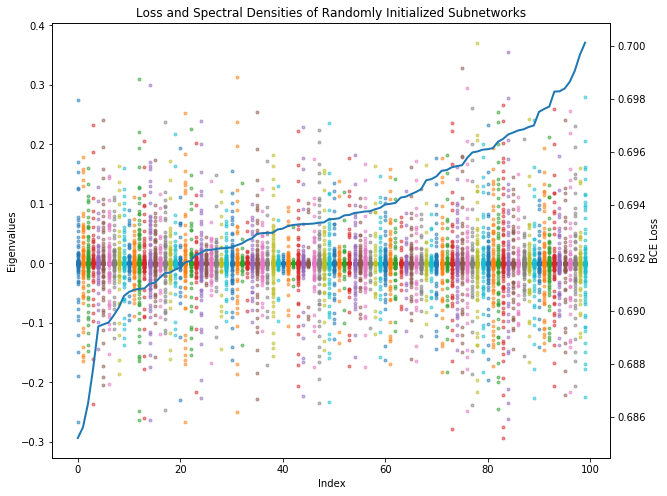

In [35]:
fig, ax1 = plt.subplots(figsize=(10,8))
for ii, tt in enumerate(idx):
    ax1.plot(torch.ones_like(e_vals[tt]) * ii, e_vals[tt],
            marker=".", alpha=0.5, linestyle='None')
ax1.set_ylabel("Eigenvalues")


ax2 = ax1.twinx()
ax2.plot(sorted_losses.detach(),
        linewidth=2.)
ax2.set_ylabel("BCE Loss")
ax1.set_xlabel("Index")
plt.title("Loss and Spectral Densities of Randomly Initialized Subnetworks");

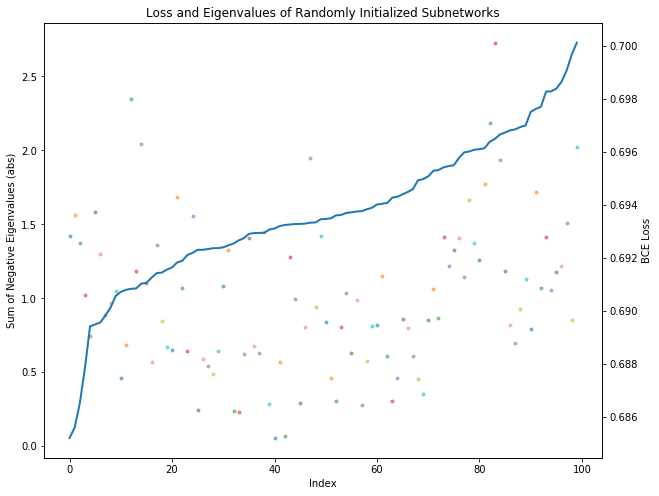

In [36]:
fig, ax1 = plt.subplots(figsize=(10,8))
for ii, tt in enumerate(idx):
    ax1.plot(ii, sum(e_vals[int(tt)][e_vals[int(0)] > 0].abs()),
            marker=".", alpha=0.5, linestyle='None')
ax1.set_ylabel("Sum of Negative Eigenvalues (abs)")


ax2 = ax1.twinx()
ax2.plot(sorted_losses.detach(),
        linewidth=2.)
ax2.set_ylabel("BCE Loss")
ax1.set_xlabel("Index")
plt.title("Loss and Eigenvalues of Randomly Initialized Subnetworks");

In [16]:
e_vals[0]

tensor([ 3.4678e-02, -3.3092e-02,  3.2389e-02, -2.7037e-02,  2.0958e-02,
         2.0763e-02, -1.8840e-02, -1.8450e-02,  1.5731e-02, -1.4579e-02,
         1.4323e-02,  1.3512e-02, -1.2854e-02, -1.0977e-02,  9.9346e-03,
         8.9915e-03, -8.8575e-03,  8.1267e-03, -7.8207e-03, -7.3661e-03,
         7.0461e-03, -6.8331e-03,  6.5909e-03,  6.2742e-03, -5.9873e-03,
        -5.5588e-03,  4.3384e-03, -4.1959e-03,  3.9577e-03, -3.8765e-03,
        -3.4718e-03, -3.3483e-03,  3.2209e-03, -3.1787e-03,  3.0439e-03,
         3.0220e-03, -2.7629e-03,  2.5720e-03, -2.5503e-03, -2.4129e-03,
         2.3933e-03,  2.3145e-03, -2.1554e-03, -2.0431e-03, -1.9063e-03,
         1.8032e-03, -1.7627e-03,  1.6769e-03, -1.6052e-03,  1.5549e-03,
         1.4783e-03,  1.4361e-03, -1.4297e-03, -1.3713e-03,  1.3457e-03,
        -1.3014e-03,  1.2567e-03, -1.2425e-03,  1.1813e-03, -1.1324e-03,
         1.0206e-03, -1.0164e-03,  1.0118e-03, -9.6566e-04, -8.7395e-04,
         8.4432e-04,  8.0137e-04, -7.2294e-04, -6.9

In [17]:
outputs = optimus(train_x.cpu())
outputs = torch.zeros_like(outputs)
ll = loss_func(outputs, train_y.cpu())

NameError: name 'optimus' is not defined

In [ ]:
ss = 0
for tsr in model.parameters():
    print(tsr.shape)
    ss += tsr.numel()

In [ ]:
ss

In [ ]:
out = hess.utils.unflatten_like(mask.unsqueeze(0), model.parameters())

In [ ]:
for tsr in out:
    print(tsr.shape)